In [1]:



from finta import TA

import pandas as pd
import yfinance as yf
import pandas as pd
from datetime import datetime
from meteostat import Point, Daily
from functools import reduce

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10



from sklearn.linear_model import SGDRegressor, Ridge
from sklearn.ensemble import RandomForestRegressor
#logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor


import warnings
warnings.filterwarnings('once')



In [2]:
import pandas as pd
import yfinance as yf
from datetime import datetime

def rsi_calculation(series, periods=14, shift=1):
    delta = series.diff()
    #shift ensures that there occurs no data leakage
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean().shift(shift)
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean().shift(shift)
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def download_stock_data(tech_list):
    end = datetime.now()
    start = datetime(end.year - 20, end.month, end.day)

    company_list = []

    for stock in tech_list:
        data = yf.download(stock, start, end)
        data['Symbol'] = stock  # Ensure 'Symbol' is a column
        company_list.append(data)

    # Concatenate with Symbol as part of the index if that is the intended structure
    df = pd.concat(company_list)
    return df

tech_stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA', 'NVDA', 'INTC', 'AMD', 'QCOM', 'IBM']
data = download_stock_data(tech_stocks)

# Remove the reset_index line if 'Symbol' is already a column
# data.reset_index(level='Symbol', inplace=True)

# Calculate moving averages with a shift
for window in [3, 7, 14, 21, 28]:
    data[f'{window}ma'] = data.groupby('Symbol')['Close'].transform(lambda x: x.shift(1).rolling(window).mean())

# Calculate RSI for each group and ensure the index aligns correctly
data['RSI_14'] = data.groupby('Symbol')['Close'].transform(lambda x: rsi_calculation(x, 14, 1))
data['RSI_no_shift'] = data.groupby('Symbol')['Close'].transform(lambda x: rsi_calculation(x, 14, 0)) #only to ensure that the shift is working correctly

print(data.tail())


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-04-15  185.570007  187.479996  180.880005  181.250000  181.250000   
2024-04-16  185.589996  185.710007  182.860001  183.750000  183.750000   
2024-04-17  184.160004  184.669998  181.779999  183.100006  183.100006   
2024-04-18  182.350006  183.460007  180.169998  181.470001  181.470001   
2024-04-19  182.429993  182.800003  180.570007  181.580002  181.580002   

             Volume Symbol         3ma         7ma        14ma        21ma  \
Date                                                                         
2024-04-15  3528100    IBM  184.736664  187.202857  188.505714  189.776667   
2024-04-16  4473700    IBM  183.139999  186.247142  187.967143  189.196667   
2024-04-17  3003000    IBM  182.423335  185.477142  187.627858  188.848095   
2024-04-18  2886700    IBM  182.700002  184.517142  187.077858  188.439048   
2024-04-19  3

In [3]:


# Assuming 'data' is your DataFrame
# Ensure your DataFrame is sorted by 'Date' if it's not already
data.sort_values(by=['Date'], inplace=True)




In [4]:
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')
data.dropna(subset=['Close','3ma', '7ma', '14ma', '21ma', '28ma', 'RSI_14' ], inplace=True)
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')
print(len(data))
print(data.info())

Number of rows with missing values: 0.005748660356827561
Number of rows with missing values: 0.0
Number of rows with missing values: 0.0
48427
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48427 entries, 2004-05-28 to 2024-04-19
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          48427 non-null  float64
 1   High          48427 non-null  float64
 2   Low           48427 non-null  float64
 3   Close         48427 non-null  float64
 4   Adj Close     48427 non-null  float64
 5   Volume        48427 non-null  int64  
 6   Symbol        48427 non-null  object 
 7   3ma           48427 non-null  float64
 8   7ma           48427 non-null  float64
 9   14ma          48427 non-null  float64
 10  21ma          48427 non-null  float64
 11  28ma          48427 non-null  float64
 12  RSI_14        48427 non-null  float64
 13  RSI_no_shift  48427 non-null  float64
dtypes: float64(12), int64(1), object(1)
me

Train error: 0.43426054834430505
Test error: 2.044439684680316


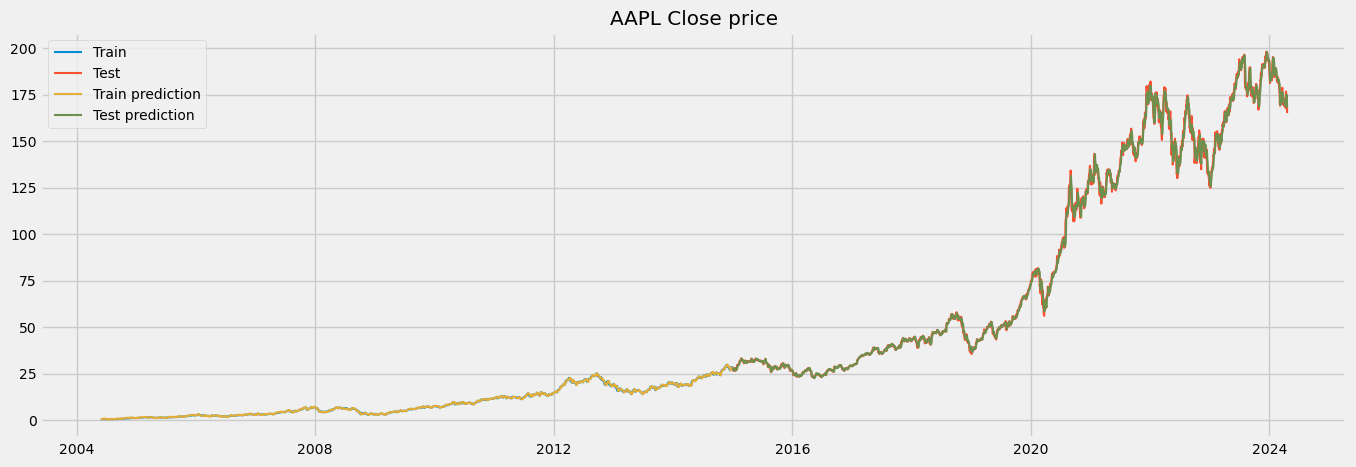

In [5]:
#forcast the close price using the 25ma and 50ma
#train the model_Ridge
#convert Date to index
#data.set_index('Date', inplace=True)

data_train = data.loc[data.index < '2015-01-01']
data_test = data.loc[data.index >= '2015-01-01']

X_train = data_train[['3ma','7ma', '14ma', '21ma', '28ma', 'RSI_14'   ]]
y_train = data_train['Close']

X_test = data_test[['3ma','7ma', '14ma', '21ma', '28ma', 'RSI_14'   ]]
y_test = data_test['Close']

#standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#train the model_Ridge
model_Ridge = Ridge()
model_Ridge.fit(X_train_scaled, y_train)

#predict the close price
y_train_pred = model_Ridge.predict(X_train_scaled)

y_test_pred = model_Ridge.predict(X_test_scaled)

#print train and test error
print(f'Train error: {mean_absolute_error(y_train, y_train_pred)}')
print(f'Test error: {mean_absolute_error(y_test, y_test_pred)}')


#filter predictions and actual values by one symbol == 'AAPL'


#plot the results
plt.figure(figsize=(15, 5))
plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, data_train.loc[data_train['Symbol'] == 'AAPL']['Close'], label='Train')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, data_test.loc[data_test['Symbol'] == 'AAPL']['Close'], label='Test')

plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, y_train_pred[data_train['Symbol'] == 'AAPL'], label='Train prediction')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, y_test_pred[data_test['Symbol'] == 'AAPL'], label='Test prediction')

plt.title('AAPL Close price')
plt.legend()


# SGQRegressor

Train error: 0.5334483971896271
Test error: 2.529009507720412


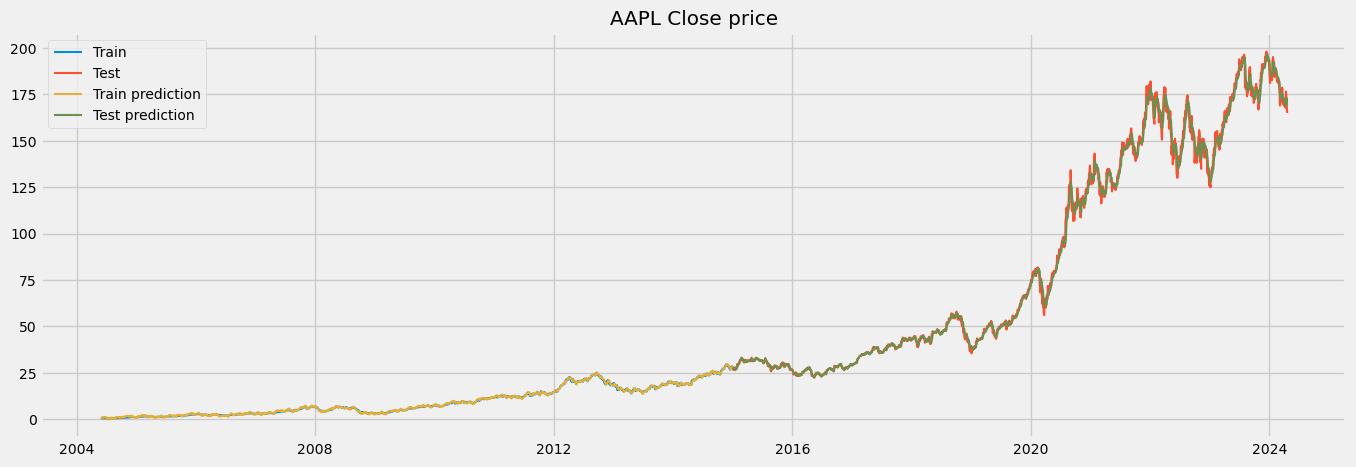

In [6]:
#forcast the close price using the 25ma and 50ma
#train the model_Ridge
data_train = data.loc[data.index < '2015-01-01']
data_test = data.loc[data.index >= '2015-01-01']

X_train = data_train[['3ma','7ma', '14ma', '21ma', '28ma', 'RSI_14'   ]]
y_train = data_train['Close']

X_test = data_test[['3ma','7ma', '14ma', '21ma', '28ma', 'RSI_14'  ]]
y_test = data_test['Close']

#standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#train the model_Ridge
model_Ridge = SGDRegressor()
model_Ridge.fit(X_train_scaled, y_train)

#predict the close price
y_train_pred = model_Ridge.predict(X_train_scaled)

y_test_pred = model_Ridge.predict(X_test_scaled)

#print train and test error
print(f'Train error: {mean_absolute_error(y_train, y_train_pred)}')
print(f'Test error: {mean_absolute_error(y_test, y_test_pred)}')


#filter predictions and actual values by one symbol == 'AAPL'


#plot the results
plt.figure(figsize=(15, 5))
plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, data_train.loc[data_train['Symbol'] == 'AAPL']['Close'], label='Train')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, data_test.loc[data_test['Symbol'] == 'AAPL']['Close'], label='Test')

plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, y_train_pred[data_train['Symbol'] == 'AAPL'], label='Train prediction')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, y_test_pred[data_test['Symbol'] == 'AAPL'], label='Test prediction')

plt.title('AAPL Close price')
plt.legend()


# XGBoost

Train error: 0.5334483971896271
Test error: 2.529009507720412


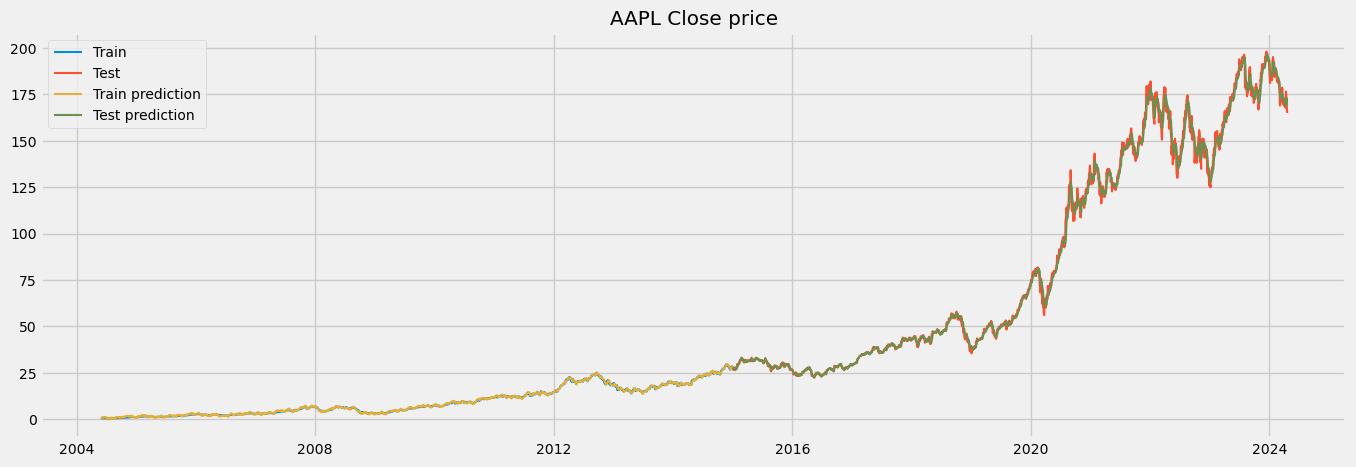

In [7]:
data_train = data.loc[data.index < '2015-01-01']
data_test = data.loc[data.index >= '2015-01-01']

X_train = data_train[['3ma','7ma', '14ma', '21ma', '28ma', 'RSI_14'   ]]
y_train = data_train['Close']

X_test = data_test[['3ma','7ma', '14ma', '21ma', '28ma', 'RSI_14'   ]]
y_test = data_test['Close']

#standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#train the model_Ridge
model = XGBRegressor(n_estimators=100)
model.fit(X_train_scaled, y_train)

#predict the close price
y_train_pred = model_Ridge.predict(X_train_scaled)

y_test_pred = model_Ridge.predict(X_test_scaled)

#print train and test error
print(f'Train error: {mean_absolute_error(y_train, y_train_pred)}')
print(f'Test error: {mean_absolute_error(y_test, y_test_pred)}')


#filter predictions and actual values by one symbol == 'AAPL'


#plot the results

plt.figure(figsize=(15, 5))
plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, data_train.loc[data_train['Symbol'] == 'AAPL']['Close'], label='Train')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, data_test.loc[data_test['Symbol'] == 'AAPL']['Close'], label='Test')

plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, y_train_pred[data_train['Symbol'] == 'AAPL'], label='Train prediction')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, y_test_pred[data_test['Symbol'] == 'AAPL'], label='Test prediction')

plt.title('AAPL Close price')
plt.legend()
plt.show()


Epoch 1/25


1565/1565 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 188.8269 - mae: 4.0840
Epoch 2/25
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.3529 - mae: 0.9762
Epoch 3/25
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.6890 - mae: 1.0200
Epoch 4/25
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.7944 - mae: 1.0217
Epoch 5/25
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.4983 - mae: 0.9752
Epoch 6/25
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.7917 - mae: 0.9938
Epoch 7/25
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.0173 - mae: 0.9074
Epoch 8/25
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.8419 - mae: 0.8777
Epoch 9/25
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.0420 - mae: 0.9104
Epoch 10/25
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.7427 - mae: 0.8686
Epoch 11/25
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.9504 - mae: 0.8885
Epoch 12/25
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.8181 - mae: 0.8698
Epoch 13/2

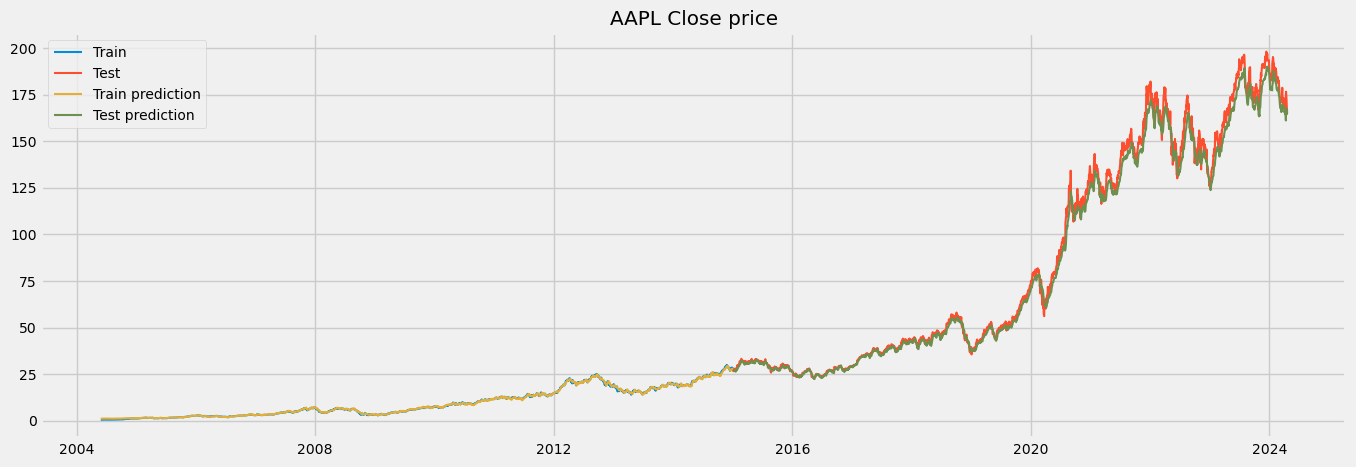

In [8]:
#predictict with a 1D Convolutional Neural Network
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from keras.layers import MaxPooling1D, Dropout

data_train = data.loc[data.index < '2015-01-01']
data_test = data.loc[data.index >= '2015-01-01']

X_train = data_train[['3ma','7ma', '14ma', '21ma', '28ma', 'RSI_14'   ]]
y_train = data_train['Close']

X_test = data_test[['3ma','7ma', '14ma', '21ma', '28ma', 'RSI_14'   ]]
y_test = data_test['Close']

shape = X_train.shape[1]
#standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

#reshape the data
X_train_reshaped = X_train_scaled.reshape(-1, shape, 1)

X_test_reshaped = X_test_scaled.reshape(-1, shape, 1)

#train the model

model = Sequential()
model.add(Conv1D(256, 2, activation='relu', input_shape=(shape, 1)))
#dropout layer
model.add(Dropout(0.2))
model.add(Conv1D(256, 2, activation='relu'))
model.add(MaxPooling1D())


model.add(Flatten())
model.add(Dense(60, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.fit(X_train_reshaped, y_train, epochs=25, verbose=1, batch_size=16)

#predict the close price
y_train_pred = model.predict(X_train_reshaped)

y_test_pred = model.predict(X_test_reshaped)

#print train and test error
print(f'Train error: {mean_absolute_error(y_train, y_train_pred)}')
print(f'Test error: {mean_absolute_error(y_test, y_test_pred)}')


#filter predictions and actual values by one symbol == 'AAPL'

plt.figure(figsize=(15, 5))

plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, data_train.loc[data_train['Symbol'] == 'AAPL']['Close'], label='Train')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, data_test.loc[data_test['Symbol'] == 'AAPL']['Close'], label='Test')

plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, y_train_pred[data_train['Symbol'] == 'AAPL'], label='Train prediction')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, y_test_pred[data_test['Symbol'] == 'AAPL'], label='Test prediction')

plt.title('AAPL Close price')
plt.legend()
plt.show()



In [9]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

data_train = data.loc[data.index < '2015-01-01']
data_test = data.loc[data.index >= '2015-01-01']

X_train = data_train[['3ma','7ma', '14ma', '21ma', '28ma', 'RSI_14'   ]]
y_train = data_train['Close']

X_test = data_test[['3ma','7ma', '14ma', '21ma', '28ma', 'RSI_14'   ]]
y_test = data_test['Close']

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

shape = X_train.shape[1]

# Reshape the data for LSTM
X_train_reshaped = X_train_scaled.reshape(-1, shape, 1)
X_test_reshaped = X_test_scaled.reshape(-1, shape, 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(256, activation='selu', input_shape=(shape, 1), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(256, activation='selu', return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128, activation='selu'))
model.add(Dropout(0.5))
model.add(Dense(60, activation='selu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
model.fit(X_train_reshaped, y_train, epochs=50, verbose=1, batch_size=32)

# Predict the close price
y_train_pred = model.predict(X_train_reshaped)
y_test_pred = model.predict(X_test_reshaped)

# Print train and test error
print(f'Train error: {mean_absolute_error(y_train, y_train_pred)}')
print(f'Test error: {mean_absolute_error(y_test, y_test_pred)}')

# Filter predictions and actual values by one symbol == 'AAPL'
plt.figure(figsize=(15, 5))

plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, data_train.loc[data_train['Symbol'] == 'AAPL']['Close'], label='Train')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, data_test.loc[data_test['Symbol'] == 'AAPL']['Close'], label='Test')

plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, y_train_pred[data_train['Symbol'] == 'AAPL'], label='Train prediction')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, y_test_pred[data_test['Symbol'] == 'AAPL'], label='Test prediction')

plt.title('AAPL Close price')
plt.legend()
plt.show()


Epoch 1/50


783/783 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - loss: 236.0756 - mae: 6.3695
Epoch 2/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - loss: 37.3060 - mae: 3.1429
Epoch 3/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - loss: 28.2641 - mae: 2.7420
Epoch 4/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - loss: 22.8359 - mae: 2.5640
Epoch 5/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - loss: 20.1968 - mae: 2.3157
Epoch 6/50
 91/783 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 16.6729 - mae: 2.2137

KeyboardInterrupt: 